# Regression Trees and Model Optimization - Lab

## Introduction

In this lab, we'll see how to apply regression analysis using CART trees while making use of some hyperparameter tuning to improve our model. 

## Objectives

In this lab you will: 

- Perform the full process of cleaning data, tuning hyperparameters, creating visualizations, and evaluating decision tree models 
- Determine the optimal hyperparameters for a decision tree model and evaluate the performance of decision tree models

## Ames Housing dataset 

The dataset is available in the file `'ames.csv'`. 

- Import the dataset and examine its dimensions: 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Load the Ames housing dataset 
data = pd.read_csv('ames.csv')

# Print the dimensions of data
print(data.shape)

# Check out the info for the dataframe
data.info()

# Show the first 5 rows
data.head()

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st     

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Identify features and target data 

In this lab, we will use using 3 predictive continuous features:

#### Features

- `LotArea`: Lot size in square feet
- `1stFlrSF`: Size of first floor in square feet
- `GrLivArea`: Above grade (ground) living area square feet

#### Target

- `SalePrice`', the sale price of the home, in dollars

- Create DataFrames for the features and the target variable as shown above 
- Inspect the contents of both the features and the target variable

In [2]:
# Features and target data
target = data['SalePrice']
features = data[['LotArea', '1stFlrSF', 'GrLivArea']]

In [3]:
target

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [4]:
features

,LotArea,1stFlrSF,GrLivArea
0,8450,856,1710
1,9600,1262,1262
2,11250,920,1786
3,9550,961,1717
4,14260,1145,2198
...,...,...,...
1455,7917,953,1647
1456,13175,2073,2073
1457,9042,1188,2340
1458,9717,1078,1078


## Inspect correlations 

- Use scatter plots to show the correlation between the chosen features and the target variable
- Comment on each scatter plot 

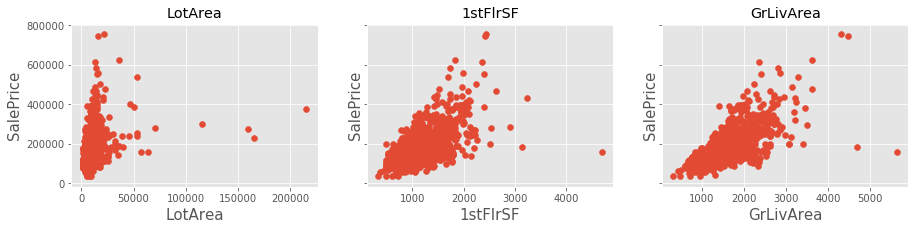

In [5]:
# Your code here

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3), sharey=True)

for n, i in enumerate(features.columns):
    axes[n].scatter(features[i], target)
    axes[n].set_title(i)
    axes[n].set_xlabel(i, fontsize=15)
    axes[n].set_ylabel('SalePrice', fontsize=15)


In [6]:
# strong correlations with 1stFlrSF and GrLivArea (graphs look similar, possibly multicolinearity)
# doesn't look like a strong correlation with LotArea

## Create evaluation metrics

- Import `r2_score` and `mean_squared_error` from `sklearn.metrics` 
- Create a function `performance(true, predicted)` to calculate and return both the R-squared score and Root Mean Squared Error (RMSE) for two equal-sized arrays for the given true and predicted values 
    - Depending on your version of sklearn, in order to get the RMSE score you will need to either set `squared=False` or you will need to take the square root of the output of the `mean_squared_error` function - check out [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) or this helpful and related [StackOverflow post](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)
    - The benefit of calculating RMSE instead of the Mean Squared Error (MSE) is that RMSE is in the same units at the target - here, this means that RMSE will be in dollars, calculating how far off in dollars our predictions are away from the actual prices for homes, on average

In [7]:
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)
    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    RMSE = np.sqrt(mean_squared_error(y_true, y_predict))
    # Return the score
    return r2, RMSE
    pass


# Test the function
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.6870225614927066]

(0.9228556485355649, 0.6870225614927066)

## Split the data into training and test sets

- Split `features` and `target` datasets into training/test data (80/20) 
- For reproducibility, use `random_state=42`

In [8]:
from sklearn.model_selection import train_test_split 

# Split the data into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Grow a vanilla regression tree

- Import the `DecisionTreeRegressor` class
- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above 
- Use `random_state=45` for tree instance
- Record your observations

In [9]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
# Set random_state=45
regressor = DecisionTreeRegressor(random_state=45)

# Fit the model to training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

# [0.5961521990414137, 55656.48543887347] - R2, RMSE

(0.5961521990414137, 55656.48543887347)

## Hyperparameter tuning (I)

- Find the best tree depth using depth range: 1-30
- Run the regressor repeatedly in a `for` loop for each depth value  
- Use `random_state=45` for reproducibility
- Calculate RMSE and r-squared for each run 
- Plot both performance measures for all runs 
- Comment on the output 

[0.3204517726895324, 0.4460775861023005, 0.5374122309538318, 0.5752501360810747, 0.6290548645964998, 0.647296309895524, 0.6596722722346179, 0.6621757798280998, 0.6365049655023539, 0.6340034577341953, 0.6223017497363402, 0.6253561763758767, 0.5954147736256159, 0.5925022512882463, 0.6206929102661053, 0.605359664414996, 0.5724186932617097, 0.6051127576219563, 0.623578649179229, 0.5853353794762683, 0.5650895037167731, 0.5869416311099844, 0.5884867360239223, 0.5986692055464062, 0.5961521990414137, 0.5961521990414137, 0.5961521990414137, 0.5961521990414137, 0.5961521990414137, 0.5961521990414137] [72196.65211758115, 65182.556010545326, 59566.761604430445, 57078.63008794533, 53341.07416910578, 52013.001812815695, 51092.3153645561, 50904.04668989568, 52802.7034278519, 52984.081287508154, 53824.42556503572, 53606.34606746578, 55707.276588432986, 55907.429392823266, 53938.93872665434, 55018.361557309014, 57268.56120750744, 55035.56998974539, 53733.36535287306, 56396.92284155655, 57757.2971789885

Text(0.5, 1.0, 'Tree Depth vs RMSE')

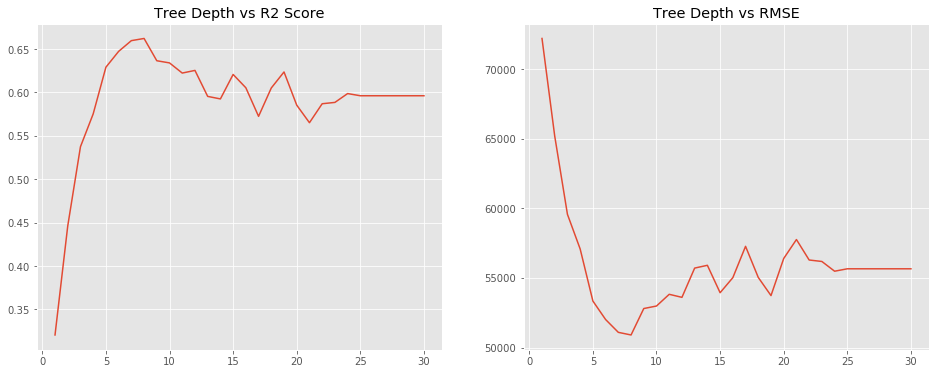

In [10]:
# Your code here 

tree_depths = np.linspace(1,30,30,endpoint=True)
R2_scores = []
RMSE_scores = []

for td in tree_depths:
    regressor = DecisionTreeRegressor(random_state=45, max_depth = td)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    score = performance(y_test, y_pred)
    R2_scores.append(score[0])
    RMSE_scores.append(score[1])
    
print(R2_scores, RMSE_scores)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,6))

ax[0].plot(tree_depths, R2_scores)
ax[0].set_title('Tree Depth vs R2 Score')

ax[1].plot(tree_depths, RMSE_scores)
ax[1].set_title('Tree Depth vs RMSE')

## Hyperparameter tuning (II)

- Repeat the above process for `min_samples_split` 
- Use a range of values from 2-10 for this hyperparameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above 

In [11]:
np.linspace(2,10,9,endpoint=True)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

[0.5961521990414137, 0.6032042998924537, 0.6183468583660242, 0.661020408419348, 0.6592880052315503, 0.6518000569540416, 0.6534411740868475, 0.6575312684099406, 0.6734642577090126] [55656.48543887347, 55168.400896111496, 54105.49042685395, 50991.019258322965, 51121.15161628739, 51679.85244257649, 51557.92126078838, 51252.7744327794, 50046.33514731985]


Text(0.5, 1.0, 'Min Samples Split vs RMSE')

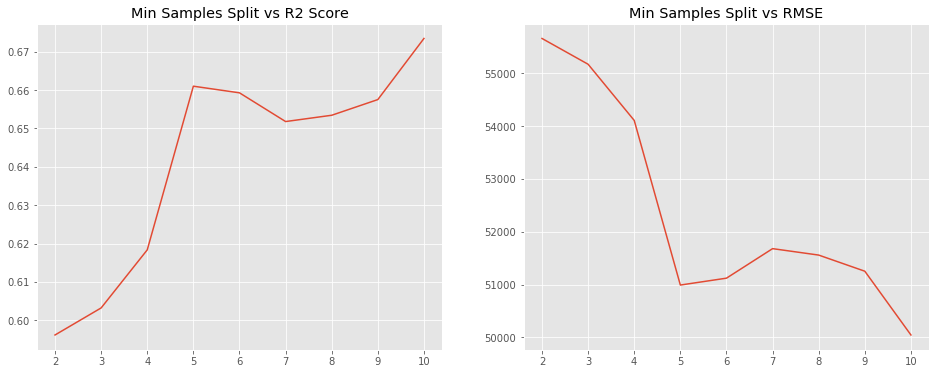

In [12]:
# Your code here 
min_samples_splits = np.linspace(2,10,9,endpoint=True).astype(int)
R2_scores = []
RMSE_scores = []

for mss in min_samples_splits:
    regressor = DecisionTreeRegressor(random_state=45, min_samples_split = mss)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    score = performance(y_test, y_pred)
    R2_scores.append(score[0])
    RMSE_scores.append(score[1])
    
print(R2_scores, RMSE_scores)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,6))

ax[0].plot(min_samples_splits, R2_scores)
ax[0].set_title('Min Samples Split vs R2 Score')

ax[1].plot(min_samples_splits, RMSE_scores)
ax[1].set_title('Min Samples Split vs RMSE')

# Run the *optimized* model 

- Use the best values for `max_depth` and `min_samples_split` found in previous runs and run an optimized model with these values 
- Calculate the performance and comment on the output 

In [13]:
# Your code here 

regressor = DecisionTreeRegressor(random_state=45, max_depth = 8, min_samples_split=10)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = performance(y_test, y_pred)

print(score)
#both measures improved a lot after tuning and pruning


(0.6797912086364211, 49559.11504625333)


## Level up (Optional)

- How about bringing in some more features from the original dataset which may be good predictors?
- Also, try tuning more hyperparameters like `max_features` to find a more optimal version of the model 

In [14]:
# Your code here 

## Summary 

In this lab, we looked at applying a decision-tree-based regression analysis on the Ames Housing dataset. We saw how to train various models to find the optimal values for hyperparameters. 